In [5]:
import os
import dowhy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Treatment (Binary): Treatment column that indicates wether the person received treatment or not
- Education (Binary): Years of education
- Black (Binary): Is black
- Hispanic (Binary): Is hispanic
- Married (Binary): Is married
- No Degree (Binary): Has High School diploma
- re74 (float): Real earnings 1974 prior study participation (pre-treatment)
- re75 (float): Real earnings 1975 prior study participation (pos-treatment)
- re78 (float): Real earnings 1978 after study participation (Y)

In [85]:
TREATMENT_PATH = "./data/ab_test"
OBSERVATIONAL_PATH = "./data/observational_data"
LALONDE_COLUMNS = ["treatment",  "age", "education", "black" , "hispanic", "married", "nodegree", "re74" , "re78"]
NSWRE_COLUMNS = ["treatment",  "age", "education", "black" , "hispanic", "married", "nodegree", "re74", "re75", "re78"]
INTEGER_COLS =  ["treatment", "age", "education", "black", "hispanic", "married", "nodegree"]

Original data from Lalonde's paper NSW experiment

In [86]:
lalonde_control = pd.read_csv(os.path.join(TREATMENT_PATH, "lalonde_control.txt"), sep='\s+',index_col=None, header=None, names=LALONDE_COLUMNS)
lalonde_treated = pd.read_csv(os.path.join(TREATMENT_PATH, "lalonde_treated.txt"), sep='\s+',index_col=None, header=None, names=LALONDE_COLUMNS)
lalonde_original = pd.concat([lalonde_control, lalonde_treated], axis=0)
assert(lalonde_original.shape[0] == 722)


Load Subset data for the NSWRE paper

In [87]:
nswre_control = pd.read_csv(os.path.join(TREATMENT_PATH, "nswre74_control.txt"), sep='\s+',index_col=None, header=None, names=NSWRE_COLUMNS)
nswre_treated = pd.read_csv(os.path.join(TREATMENT_PATH, "nswre74_treated.txt"), sep='\s+',index_col=None, header=None, names=NSWRE_COLUMNS)
nswre_df = pd.concat([nswre_control, nswre_treated], axis=0)
nswre_df["origin"] = "NSWRE"
assert(nswre_df.shape[0] == 445)

Load Observational Data

In [88]:
cps_control = pd.read_csv(os.path.join(OBSERVATIONAL_PATH, "cps_controls.txt"), sep='\s+',index_col=None, header=None, names=NSWRE_COLUMNS)
cps_control["origin"] = "CPS"
assert(cps_control.shape[0] == 15992)
psid_control = pd.read_csv(os.path.join(OBSERVATIONAL_PATH, "psid_controls.txt"), sep='\s+',index_col=None, header=None, names=NSWRE_COLUMNS)
psid_control["origin"] = "PSID"
assert(psid_control.shape[0] == 2490)

Combine all datasets into one (we wont use Lalonde dataset for now)

In [89]:
final_df = pd.concat([nswre_df, cps_control, psid_control], axis=0)
final_df[INTEGER_COLS] = final_df[INTEGER_COLS].astype("int64")
final_df.head()
assert(final_df.shape[0] == 2490+15992+445)

In [90]:
final_df[(final_df["treatment"]==1) & (final_df["origin"]=="CPS")]

,treatment,age,education,black,hispanic,married,nodegree,re74,re75,re78,origin


# EDA

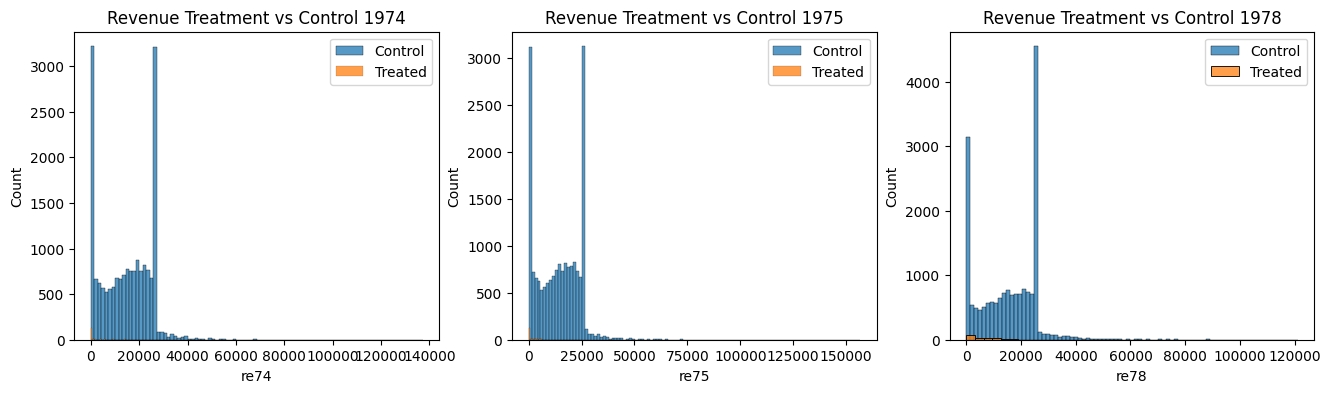

In [69]:
# Create a grid of plots with 1 row and 4 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(final_df[final_df["treatment"]==0]["re74"], label="Control", ax=axes[0])
sns.histplot(final_df[final_df["treatment"]==1]["re74"], label="Treated", ax=axes[0])

sns.histplot(final_df[final_df["treatment"]==0]["re75"], label="Control", ax=axes[1])
sns.histplot(final_df[final_df["treatment"]==1]["re75"], label="Treated", ax=axes[1])

sns.histplot(final_df[final_df["treatment"]==0]["re78"], label="Control", ax=axes[2])
sns.histplot(final_df[final_df["treatment"]==1]["re78"], label="Treated", ax=axes[2])

axes[0].set_title("Revenue Treatment vs Control 1974")
axes[0].legend()
axes[1].set_title("Revenue Treatment vs Control 1975")
axes[1].legend()
axes[2].set_title("Revenue Treatment vs Control 1978")
plt.legend()
plt.show()

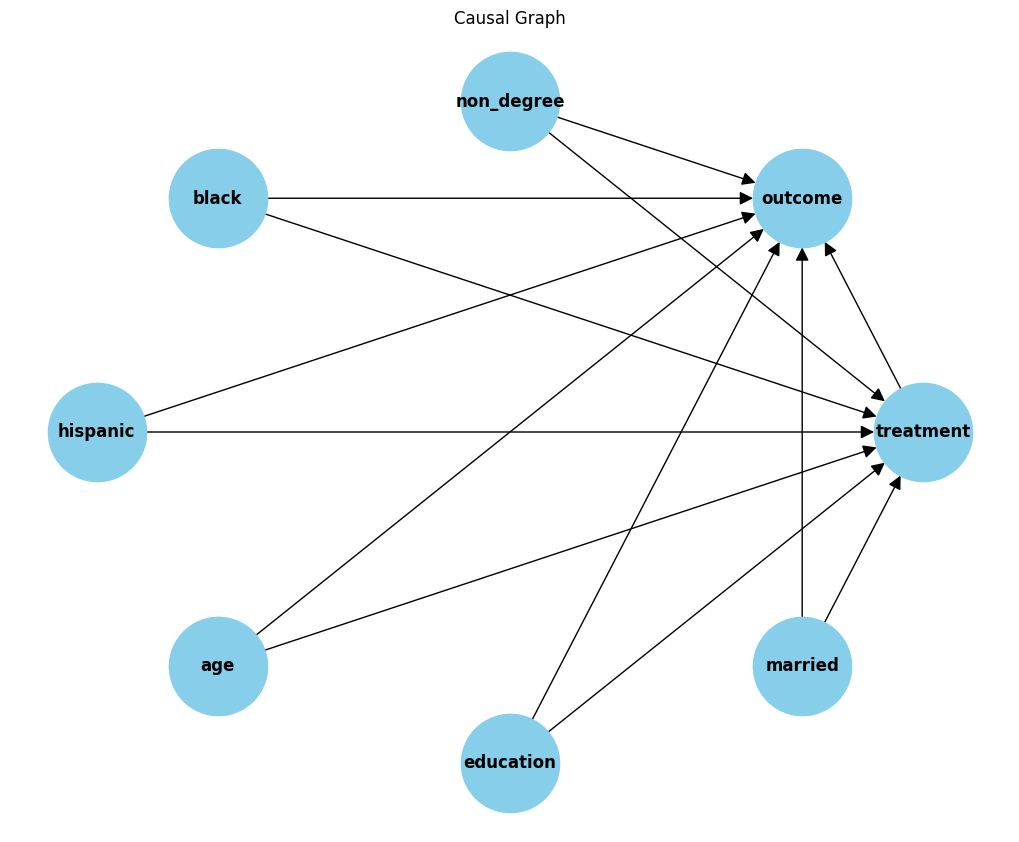

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


# Define the causal graph structure
causal_edges = [("treatment", "outcome"), ("non_degree", "treatment"), ("black", "treatment"),
                ("hispanic", "treatment"), ("age", "treatment"), ("education", "treatment"),
                ("married", "treatment"), ("non_degree", "outcome"), ("black", "outcome"),
                ("hispanic", "outcome"), ("age", "outcome"), ("education", "outcome"),
                ("married", "outcome")]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
G.add_edges_from(causal_edges)

# Draw the graph using the circular layout
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)  # Circular layout
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
plt.title("Causal Graph")
plt.show()

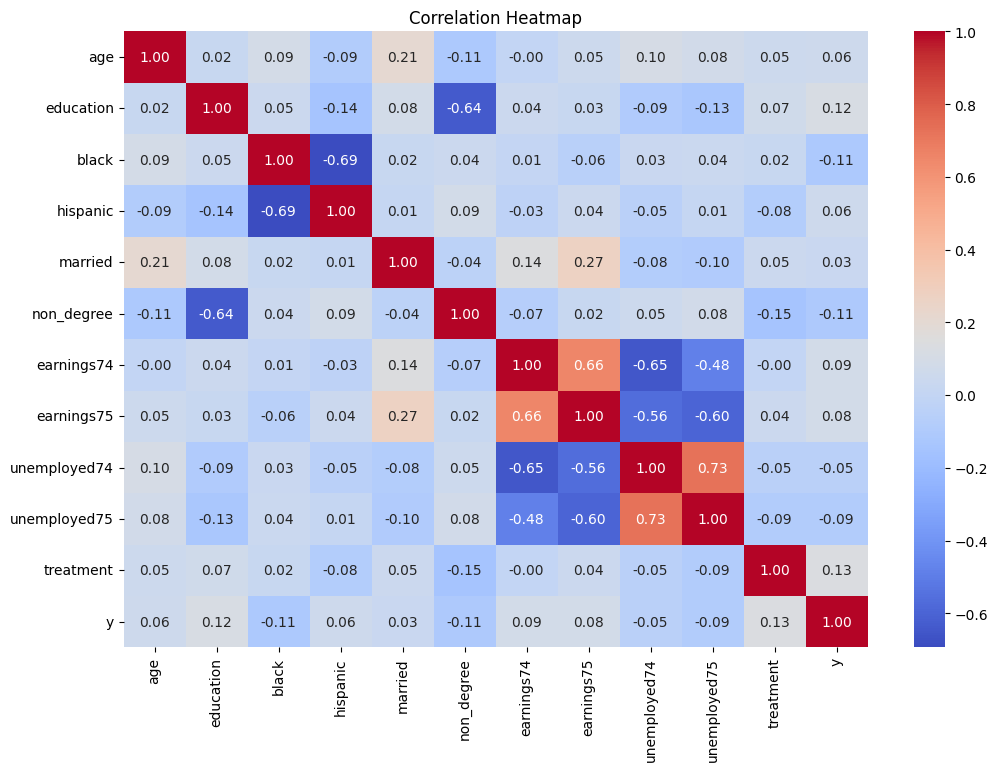

In [9]:
correlation_matrix = lalonde_df.corr()
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [3]:
model=dowhy.CausalModel(
        data = lalonde_df,
        treatment='treatment',
        outcome='y',
        common_causes=["non_degree", "black" ,"hispanic", "age", "education","married"])
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units="ate",
        method_params={"weighting_scheme":"ips_weight"})
#print(estimate)
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1639.9011436609135


c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\dowhy\interpreters\confounder_distribution_interpreter.py:87: FutureWarning: The provided callable <function sum at 0x0000021412099E40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  barplot_df_after = df.groupby([self.var_name, treated]).agg({"weight": np.sum}).reset_index()


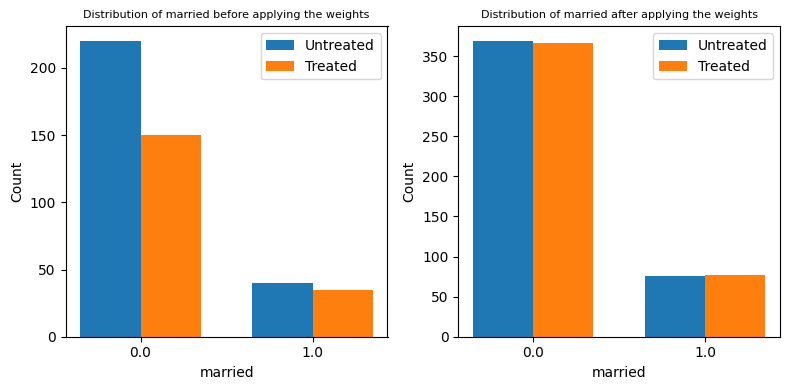

In [4]:
estimate.interpret(method_name="confounder_distribution_interpreter",var_type='discrete',
                   var_name='married', fig_size = (8, 4), font_size = 8)

Proving the ATE

In [5]:
df = model._data
ps = df['propensity_score']
y = df['y']
z = df['treatment']

ey1 = z*y/ps / sum(z/ps)
ey0 = (1-z)*y/(1-ps) / sum((1-z)/(1-ps))
ate = ey1.sum()-ey0.sum()
print("Causal Estimate is " + str(ate))

Causal Estimate is 1639.9011436609135
